In [2]:
# !pip3 install opencv-python
# !apt-get update && apt-get install libgl1

import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time

import matplotlib.pyplot as plt

In [24]:
path = os.getcwd()
data_path = os.getcwd()
proj_path = os.getcwd()
# data_path = os.path.join(path,'cmaqProjectdata')
# proj_path = os.path.join(path,'repos','cmaqProject')

* 데이터셋

In [5]:
avg_conc_path_list = glob(os.path.join(data_path,"연평균자료","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

avg_ems_path_list = glob(os.path.join(data_path,"연평균자료","emission","*"))
avg_ems_path_info_df = pd.DataFrame()
avg_ems_path_info_df.loc[:,'path_ems'] = avg_ems_path_list
avg_ems_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_ems_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"연평균자료","02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, avg_ems_path_info_df, how='left', on='Run')
merged_info_df = pd.merge(merged_info_df, cont_matrix, how='left', on='Run')

target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]


smoke_list = [Dataset(path, 'r') for path in merged_info_df.path_ems.tolist()]
smoke_chem_list = ['SO2', 'PM2_5', 'NOx', 'VOCs', 'NH3', 'CO']
smoke_val_list = []
for i in smoke_chem_list:
    smoke_arr_i = np.concatenate([np.array(Dataset(path, 'r').variables[i][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path_ems.tolist()])[:,:,:,None]
    smoke_val_list.append(smoke_arr_i)

smoke_arr = np.concatenate(smoke_val_list, axis = 3)
smoke_arr.shape, target_arr.shape
input_cols = list(set(merged_info_df.columns) - set(['path','Run','path_ems']))

control_matrix = merged_info_df.loc[:,input_cols].values

In [6]:
control_matrix.shape, target_arr.shape, smoke_arr.shape

((120, 119), (120, 64, 64, 1), (120, 64, 64, 6))

In [7]:
control_matrix_df = merged_info_df.loc[:,input_cols]

In [8]:
control_matrix_df.head()

,76)K_ALL_SLV,118)Q_ALL_SLV,20)C_ALL_SLV,56)H_ALL_OTH,37)F_ALL_IND,53)H_ALL_RES,89)M_NH3_AGR,102)O_ALL_RES,47)G_NH3_AGR,34)E_ALL_SLV,...,86)M_ALL_IND,69)J_ALL_SLV,60)I_ALL_RES,2)A_ALL_IND,7)A_ALL_OTH,18)C_ALL_RES,36)F_ALL_POW,49)G_ALL_OTH,15)C_ALL_POW,104)O_ALL_SLV
0,1.466911,0.617710,0.910300,0.687540,0.999427,0.675043,0.901897,1.110475,1.024060,0.554612,...,0.669803,1.345981,1.148908,1.261603,1.438822,0.669493,0.844979,1.232925,1.310016,0.766653
1,1.135802,0.908958,0.590837,1.109742,1.111286,1.058311,1.443239,1.079175,1.429606,1.397805,...,1.044010,1.181885,1.223899,0.770109,1.372776,0.544246,1.088189,1.317502,1.444050,0.891018
2,0.780988,1.064223,1.374211,1.137256,0.784483,0.689562,1.487370,0.512255,1.286222,1.244911,...,1.209896,1.092554,1.079884,0.797480,0.979013,0.765030,1.255467,1.250139,1.279427,1.251179
3,0.591270,1.113142,0.984195,0.911575,1.375658,1.489493,1.400701,1.199570,1.467864,1.170867,...,0.727324,0.563351,0.788804,0.601578,0.884281,1.308486,0.720941,1.088656,1.052766,1.281176
4,1.378221,0.662836,1.127108,0.633919,1.022232,1.088153,1.149661,0.548986,0.778194,0.782522,...,0.846351,1.255380,1.431172,1.394097,0.931919,0.742694,0.976683,1.194130,0.983299,1.059567


* control matrix correlation

<Axes: >

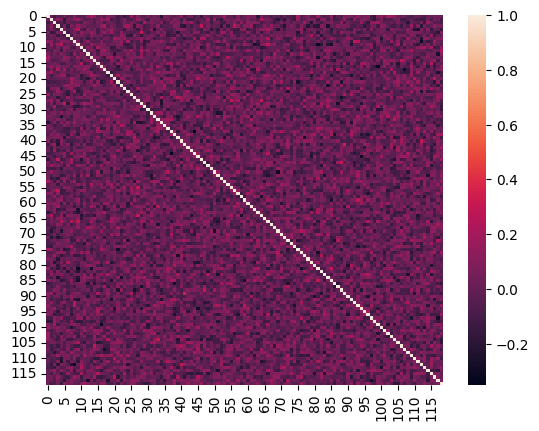

In [9]:
# 컨트롤 매트릭스간 상관관계 히트맵맵
sns.heatmap(control_matrix_df.corr(method='pearson').values)

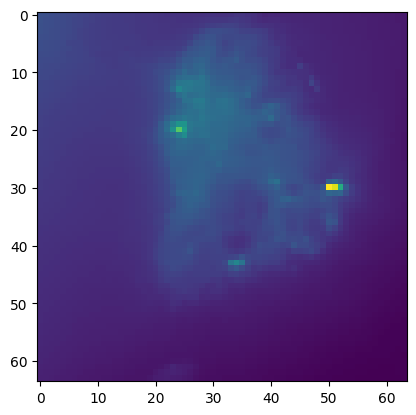

In [11]:
#전체 이미지
plt.imshow(target_arr[0][::-1])

<Axes: ylabel='Count'>

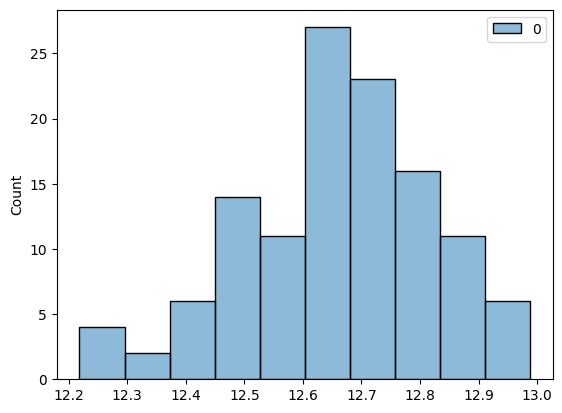

In [12]:
# 64*64 120개 시나리오 평균농도 분포
sns.histplot(np.mean(target_arr, axis = (1,2)))

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, np.mean(target_arr, axis = (1,2)), test_size=0.2, random_state=42 )

rand_reg = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=200)
rand_reg.fit(X_train, y_train)

y_pred_train = rand_reg.predict(X_train)
y_pred = rand_reg.predict(X_test)

print('훈련세트 mse성능: {:.3f}' .format(mean_squared_error(y_train, y_pred_train, squared= True)))
print('테스트세트 mse성능: {:.3f}' .format(mean_squared_error(y_test, y_pred, squared= True)))

print('훈련세트 rmse성능: {:.3f}' .format(mean_squared_error(y_train, y_pred_train, squared= False)))
print('테스트세트 rmse성능: {:.3f}' .format(mean_squared_error(y_test, y_pred, squared= False)))

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3692\324868178.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand_reg.fit(X_train, y_train)


훈련세트 mse성능: 0.007
테스트세트 mse성능: 0.012
훈련세트 rmse성능: 0.086
테스트세트 rmse성능: 0.109


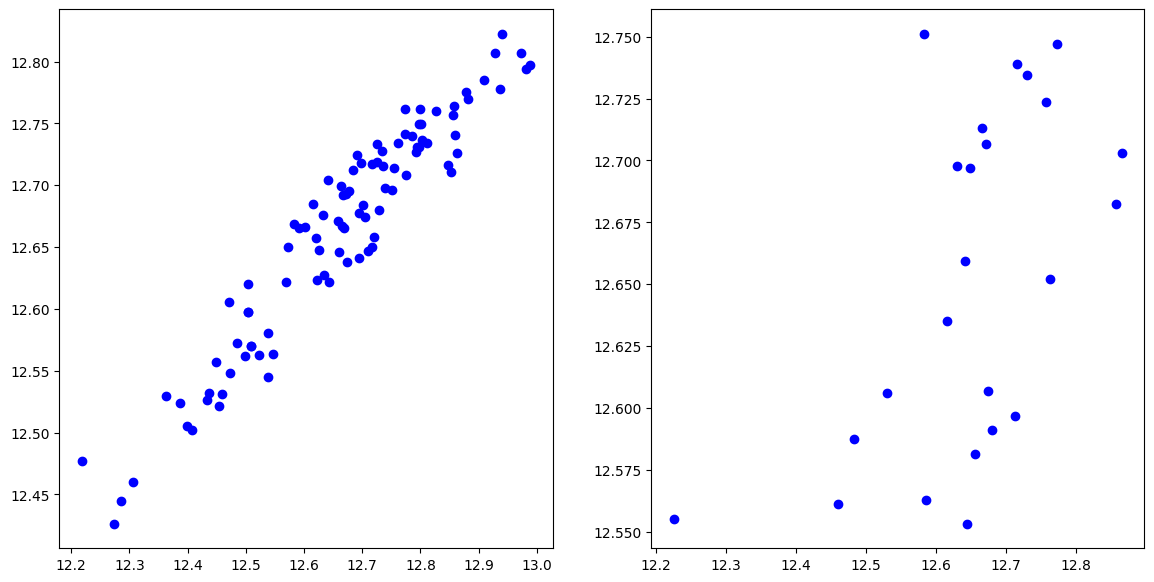

In [17]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(y_train, y_pred_train, 'bo')

plt.subplot(1,2,2)
plt.plot(y_test, y_pred, 'bo')

* 포항쪽만

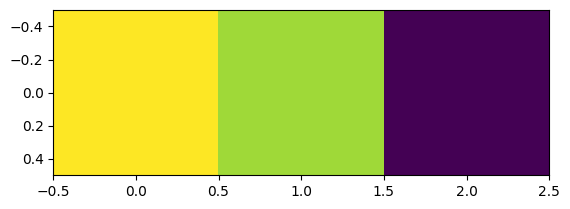

In [18]:
#포항쪽만 이미지
plt.imshow(target_arr[0][33:34,50:53,:])

<Axes: ylabel='Count'>

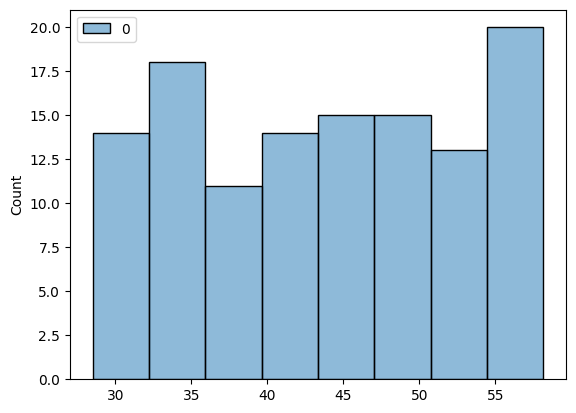

In [19]:
# 포항만 120개 시나리오 평균농도 분포
sns.histplot(np.mean(target_arr[:,33:34,50:53,:], axis = (1,2)))

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, np.mean(target_arr[:,33:34,50:53,:], axis = (1,2)), test_size=0.2, random_state=42 )

rand_reg = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=200)
rand_reg.fit(X_train, y_train)

y_pred_train = rand_reg.predict(X_train)
y_pred = rand_reg.predict(X_test)

print('훈련세트 mse성능: {:.3f}' .format(mean_squared_error(y_train, y_pred_train, squared= True)))
print('테스트세트 mse성능: {:.3f}' .format(mean_squared_error(y_test, y_pred, squared= True)))

print('훈련세트 rmse성능: {:.3f}' .format(mean_squared_error(y_train, y_pred_train, squared= False)))
print('테스트세트 rmse성능: {:.3f}' .format(mean_squared_error(y_test, y_pred, squared= False)))

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3692\3399466043.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand_reg.fit(X_train, y_train)


훈련세트 mse성능: 0.384
테스트세트 mse성능: 0.880
훈련세트 rmse성능: 0.620
테스트세트 rmse성능: 0.938


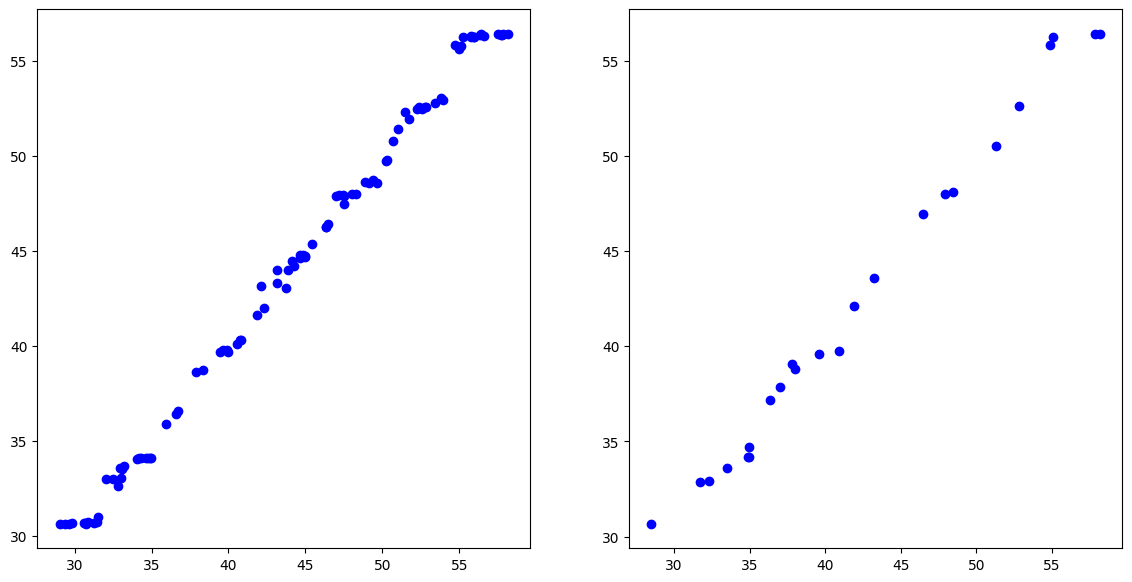

In [21]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(y_train, y_pred_train, 'bo')

plt.subplot(1,2,2)
plt.plot(y_test, y_pred, 'bo')

* 1*1 으로 64*64 전체 픽셀 확인

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
results_pd = pd.DataFrame(columns=['id','train_mse','test_mse','train_rmse','test_rmse','train_r2','test_r2','x','y'])
# X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, np.mean(target_arr[:,x_start:x_end,y_start:y_end,:], axis = (1,2)), test_size=0.2, random_state=42 )
X_train, X_test, y_train, y_test = train_test_split(control_matrix_df, target_arr, test_size=0.2, random_state=42 )
models = []

ind_count = 0
for i in range(64):
    for j in range(64):
        # print(i)
        x_start = i
        y_start = j

        y_train_sub = y_train[:,x_start,y_start,:]
        y_test_sub = y_test[:,x_start,y_start,:]

        # plt.figure(figsize = [10,10])
        # plt.subplot(2,2,1)
        # plt.imshow(target_arr[0][x_start:x_end,y_start:y_end,:])

        # plt.subplot(2,2,2)
        # sns.histplot(np.mean(target_arr[:,x_start:x_end,y_start:y_end,:], axis = (1,2)))

        rand_reg = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=50)
        rand_reg.fit(X_train, y_train_sub.ravel())
        models.append(rand_reg)

        y_pred_train = rand_reg.predict(X_train)
        y_pred = rand_reg.predict(X_test)

        # plt.subplot(2,2,3)
        # plt.plot(y_train, y_pred_train, 'bo')

        # plt.subplot(2,2,4)
        # plt.plot(y_test, y_pred, 'bo')



        train_mse = mean_squared_error(y_train_sub, y_pred_train, squared= True)
        test_mse = mean_squared_error(y_test_sub, y_pred, squared= True)

        train_rmse = mean_squared_error(y_train_sub, y_pred_train, squared= False)
        test_rmse = mean_squared_error(y_test_sub, y_pred, squared= False)

        train_r2 = r2_score(y_train_sub, y_pred_train,)
        test_r2 = r2_score(y_test_sub, y_pred,)

        results_pd.loc[ind_count,:] = [i,train_mse,test_mse,train_rmse,test_rmse,train_r2,test_r2,i,j]
        ind_count += 1

        # plt.savefig(os.path.join(proj_path,'plots','1pix_test_plots',f'{i}_{j}.png'))
        # plt.close()
results_pd.to_csv(os.path.join(proj_path,'plots','1pix_test_plots','results.csv'))
results_pd.loc[:,'model'] = models

In [28]:
results_pd

,id,train_mse,test_mse,train_rmse,test_rmse,train_r2,test_r2,x,y,model
0,0,0.000141,0.000173,0.011881,0.013164,0.765941,0.438641,0,0,"(DecisionTreeRegressor(max_depth=3, max_featur..."
1,0,0.000147,0.000186,0.012115,0.013636,0.777797,0.424836,0,1,"(DecisionTreeRegressor(max_depth=3, max_featur..."
2,0,0.000153,0.000205,0.012356,0.01431,0.783016,0.382407,0,2,"(DecisionTreeRegressor(max_depth=3, max_featur..."
3,0,0.000158,0.000215,0.012551,0.014669,0.79477,0.431484,0,3,"(DecisionTreeRegressor(max_depth=3, max_featur..."
4,0,0.000174,0.000249,0.01318,0.015776,0.790681,0.383488,0,4,"(DecisionTreeRegressor(max_depth=3, max_featur..."
...,...,...,...,...,...,...,...,...,...,...
4091,63,0.00259,0.003282,0.050893,0.057292,0.757947,0.404825,63,59,"(DecisionTreeRegressor(max_depth=3, max_featur..."
4092,63,0.002545,0.003458,0.050445,0.058802,0.750589,0.360348,63,60,"(DecisionTreeRegressor(max_depth=3, max_featur..."
4093,63,0.00242,0.002769,0.04919,0.052618,0.746281,0.462922,63,61,"(DecisionTreeRegressor(max_depth=3, max_featur..."
4094,63,0.002297,0.002616,0.04793,0.051149,0.741188,0.473889,63,62,"(DecisionTreeRegressor(max_depth=3, max_featur..."


<Axes: ylabel='Count'>

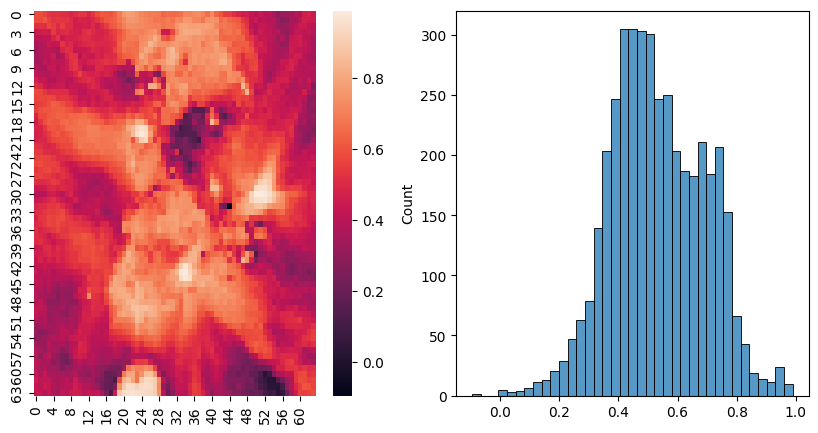

In [29]:
r2_map = np.zeros_like(target_arr[0])
for ind in range(len(results_pd)):
    ind_val = results_pd.loc[ind,['x', 'y', 'test_r2']].values
    r2_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(r2_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(r2_map[:,:,0][::-1].reshape(-1))

<Axes: ylabel='Count'>

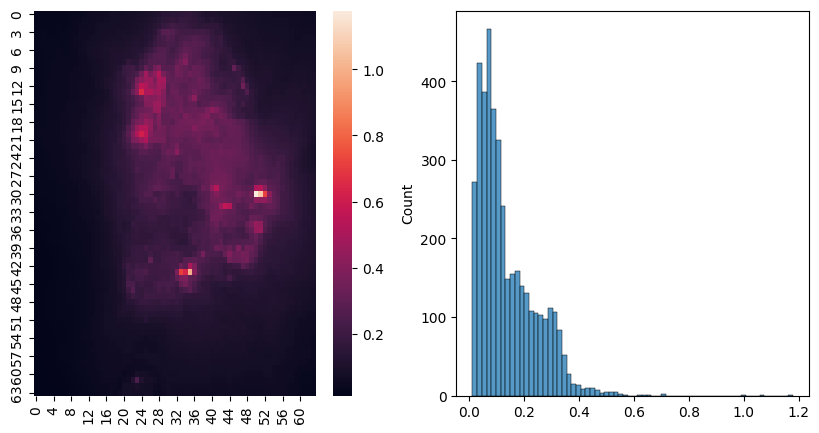

In [30]:
rmse_map = np.zeros_like(target_arr[0])
for ind in range(len(results_pd)):
    ind_val = results_pd.loc[ind,['x', 'y', 'test_rmse']].values
    rmse_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(rmse_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(rmse_map[:,:,0][::-1].reshape(-1))


<Axes: ylabel='Count'>

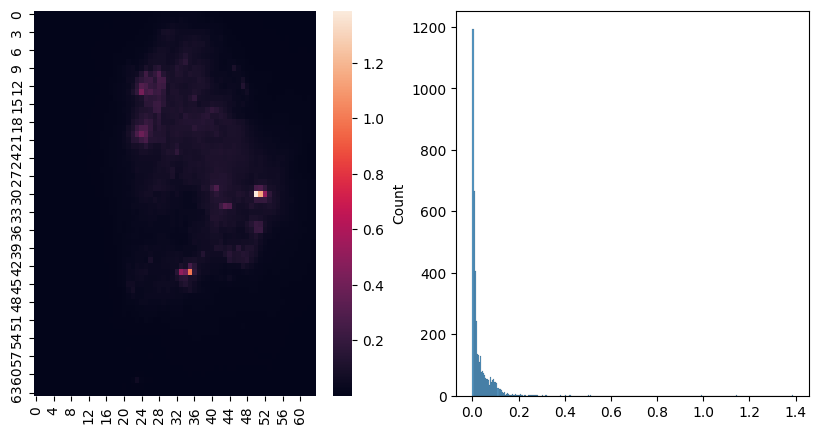

In [31]:
mse_map = np.zeros_like(target_arr[0])
for ind in range(len(results_pd)):
    ind_val = results_pd.loc[ind,['x', 'y', 'test_mse']].values
    mse_map[ind_val[0],ind_val[1],0] = ind_val[2]

plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
sns.heatmap(mse_map[:,:,0][::-1])

plt.subplot(1,2,2)
sns.histplot(mse_map[:,:,0][::-1].reshape(-1))


In [32]:
pred_base = np.zeros_like(y_test)
for ind in range(len(results_pd)):
    ind_val = results_pd.loc[ind,:].values
    pred = ind_val[9].predict(X_test)

    pred_base[:,ind_val[7],ind_val[8],0] = pred

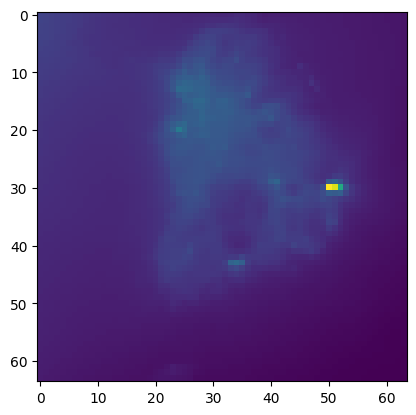

In [33]:
plt.imshow(pred_base[0][::-1])

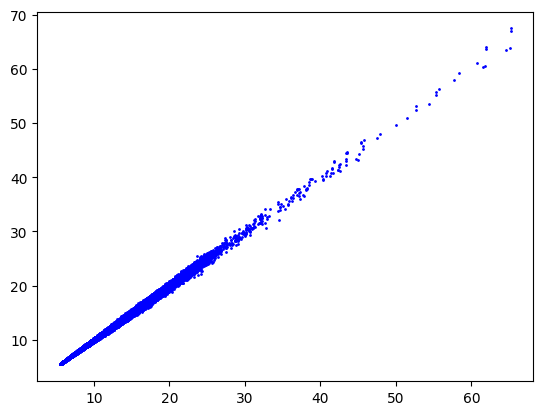

In [34]:
plt.plot(pred_base.reshape(-1), y_test.reshape(-1), 'bo', markersize = 1)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3692\3267614228.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = [15,5])


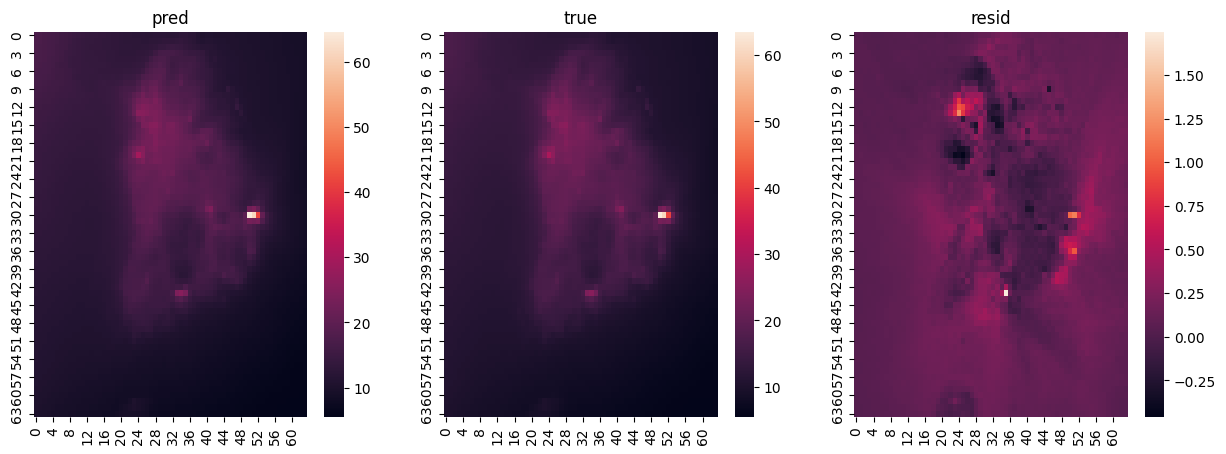

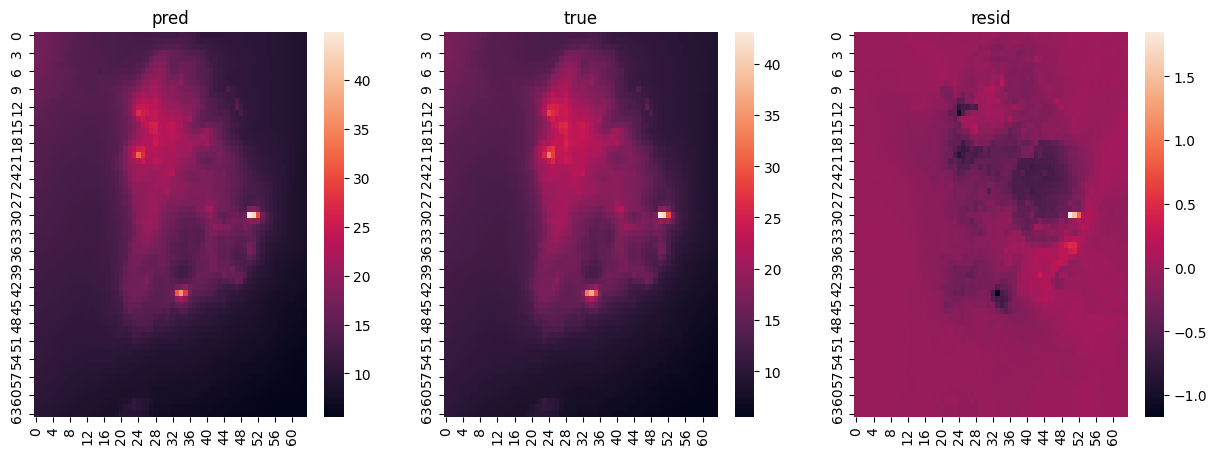

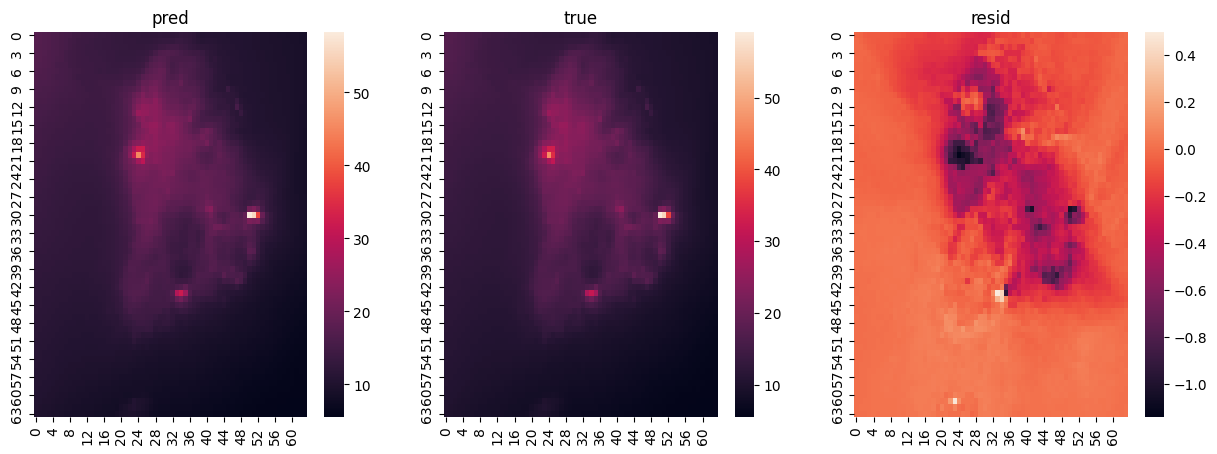

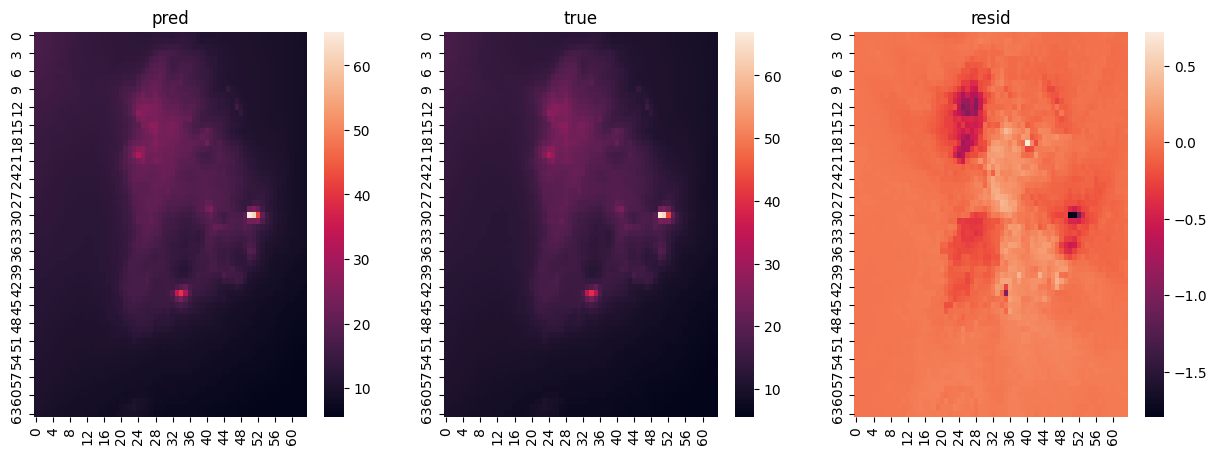

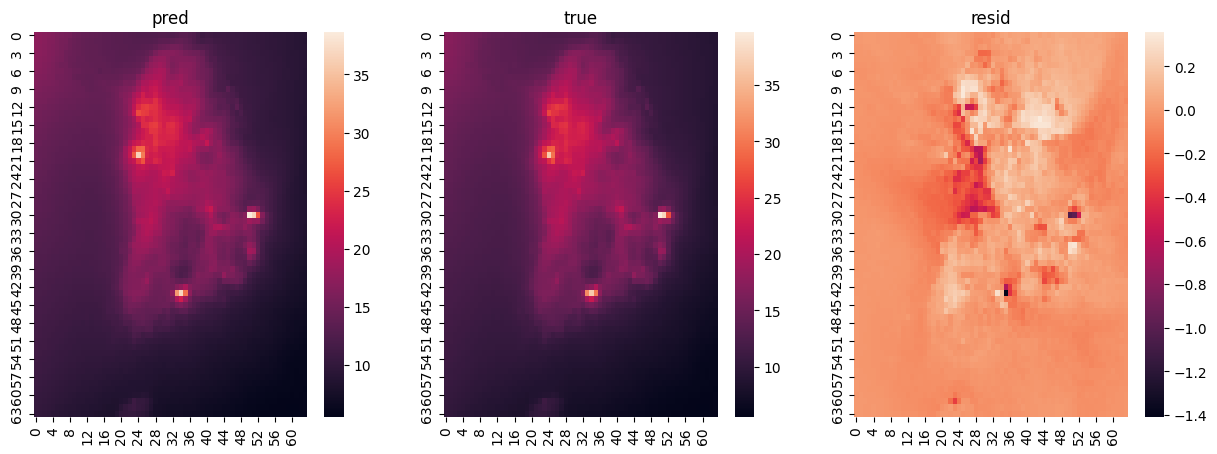

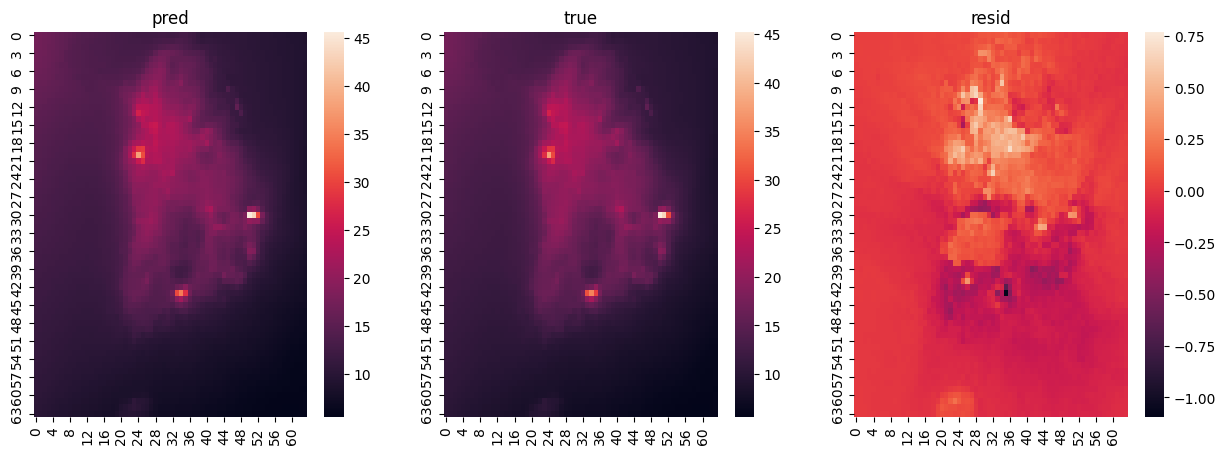

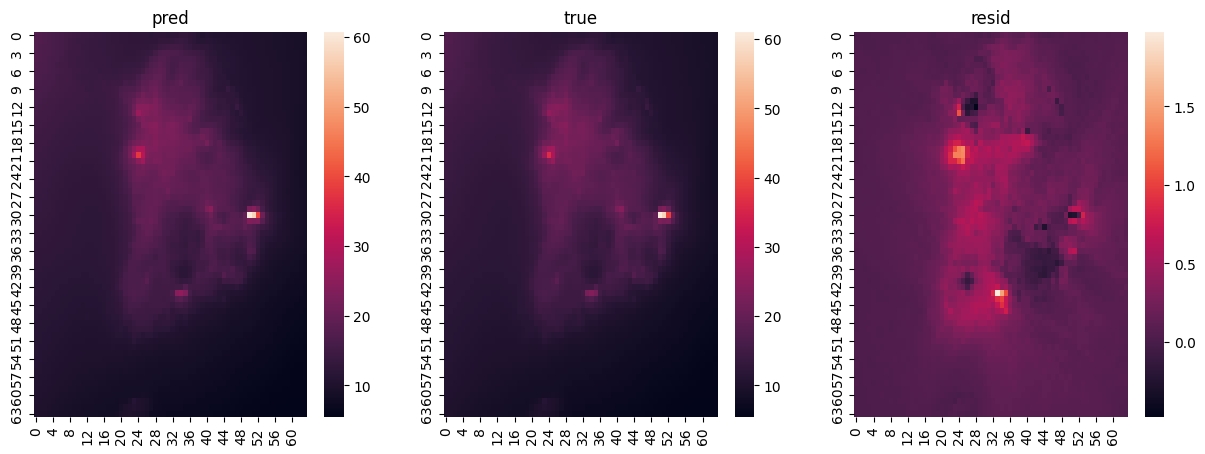

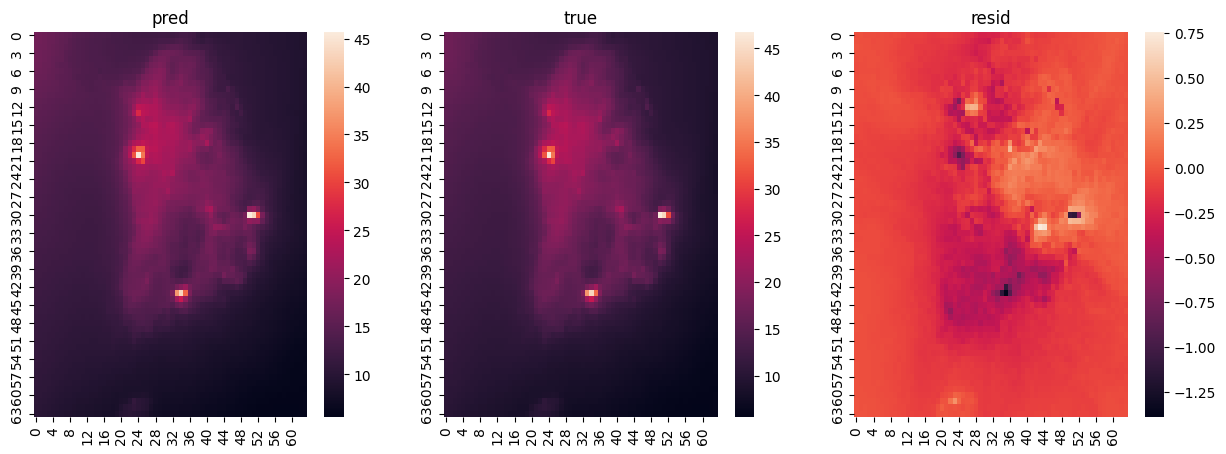

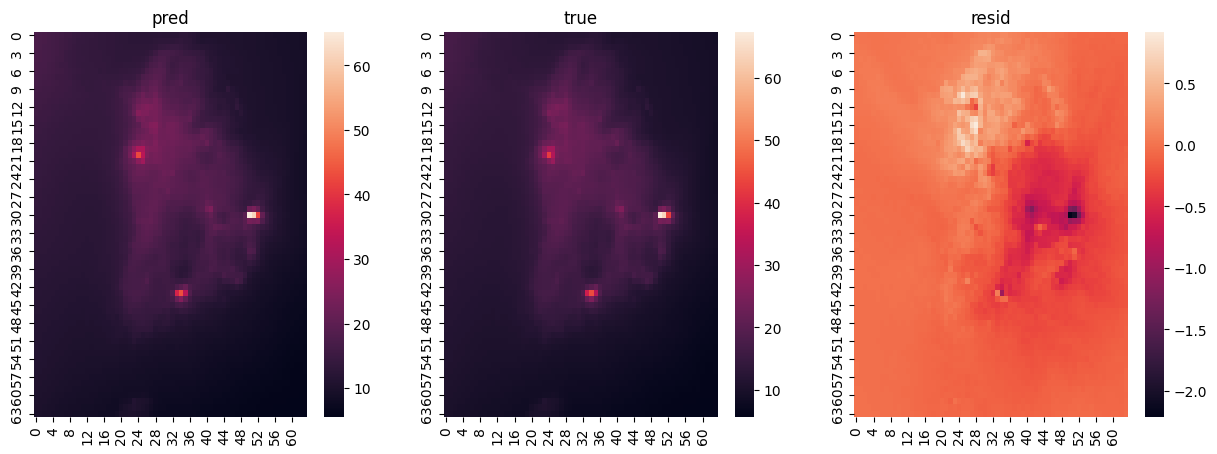

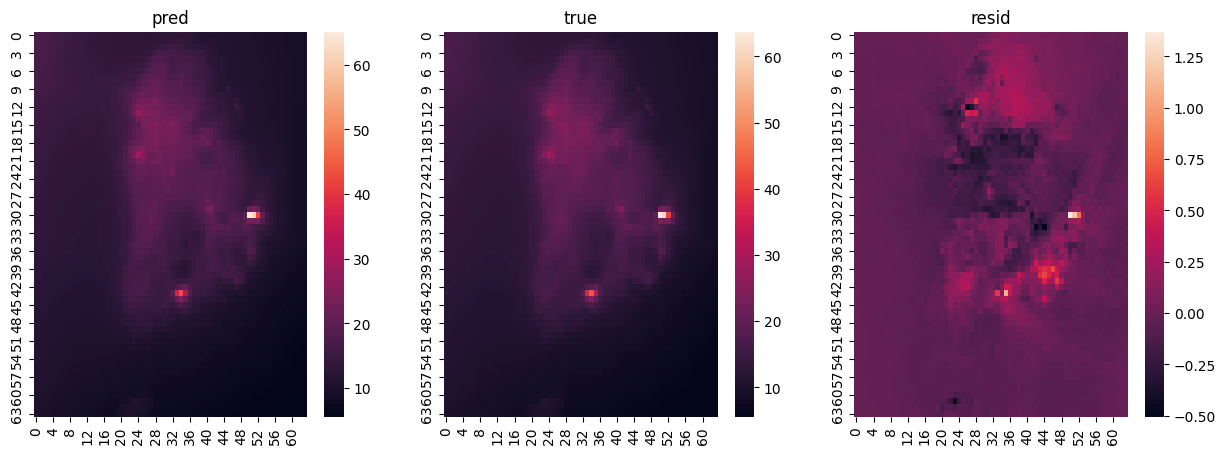

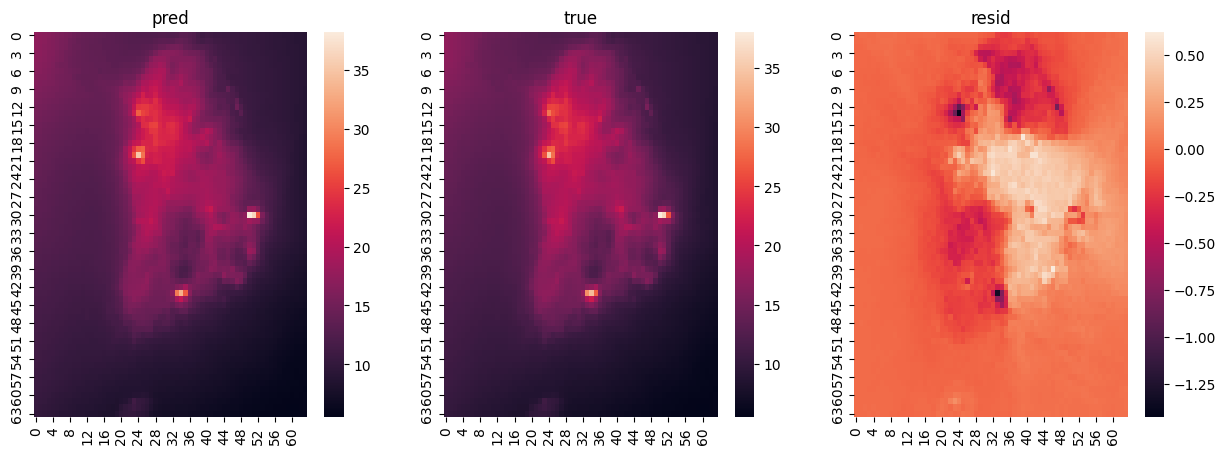

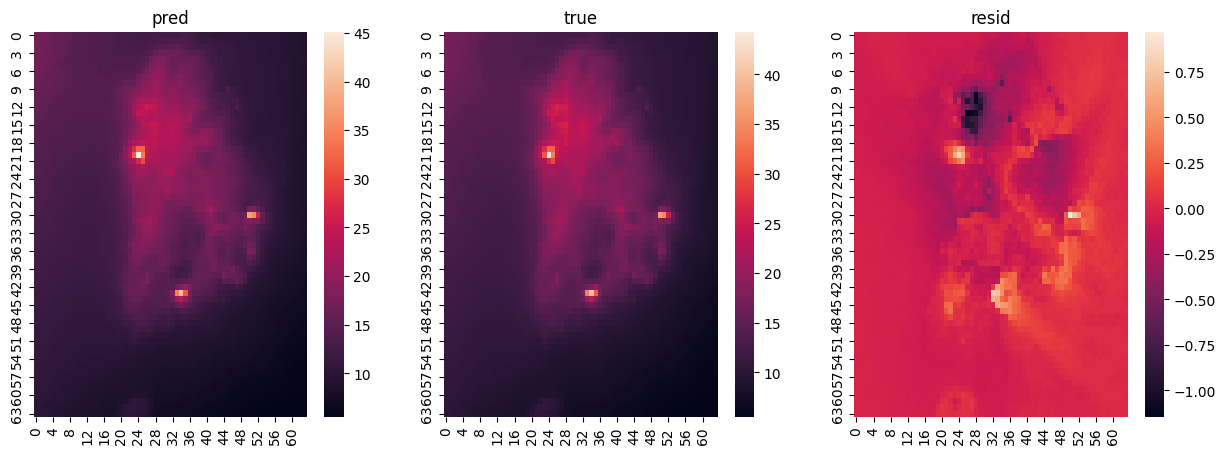

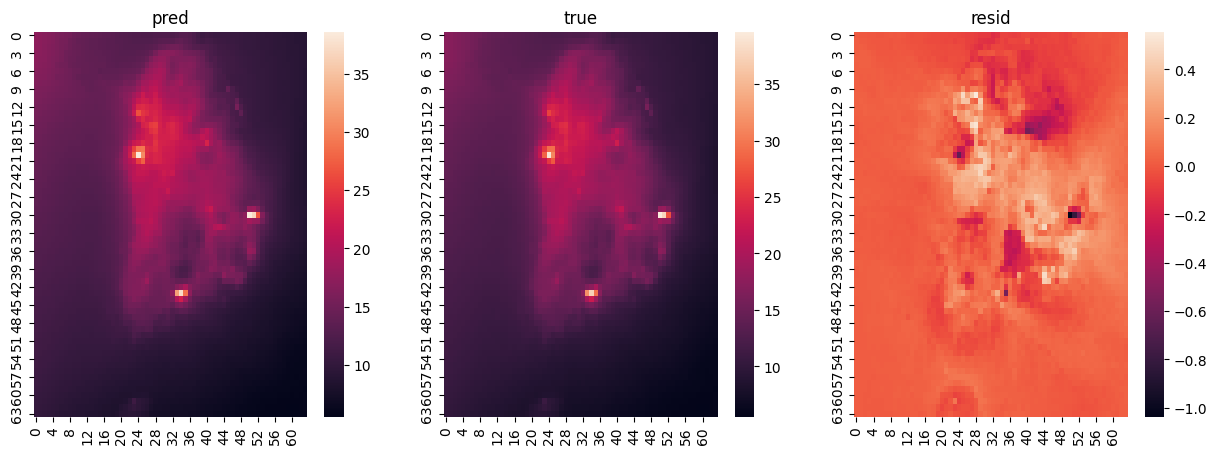

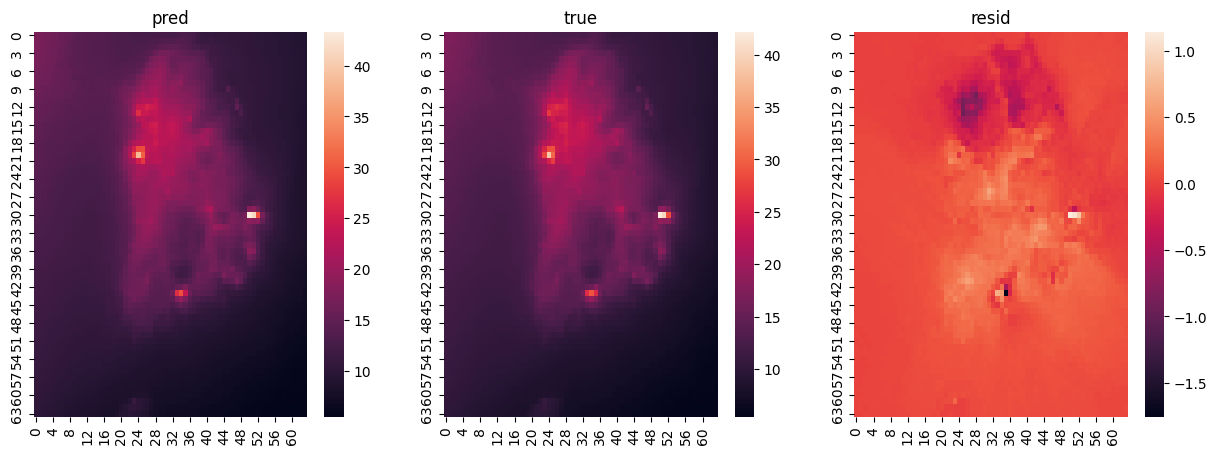

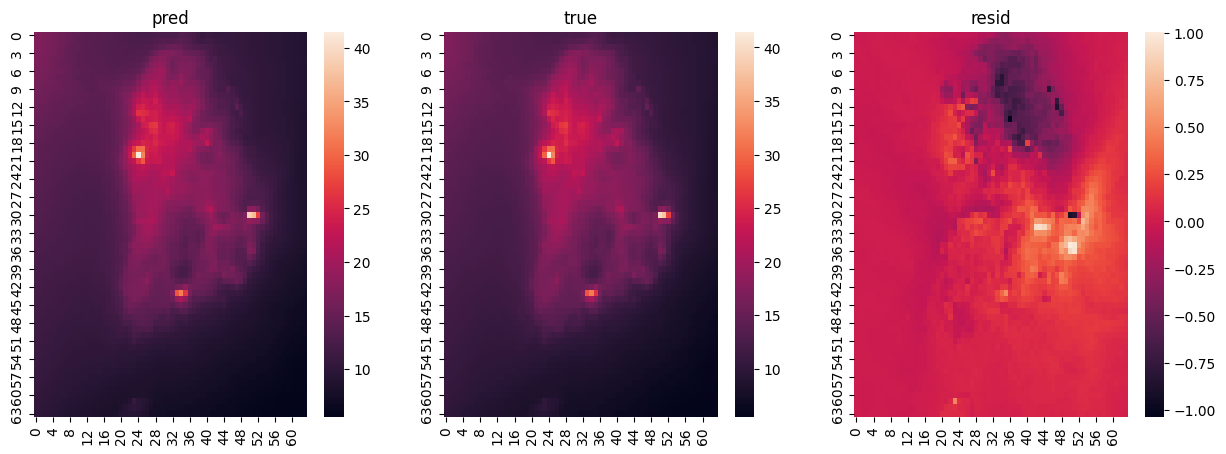

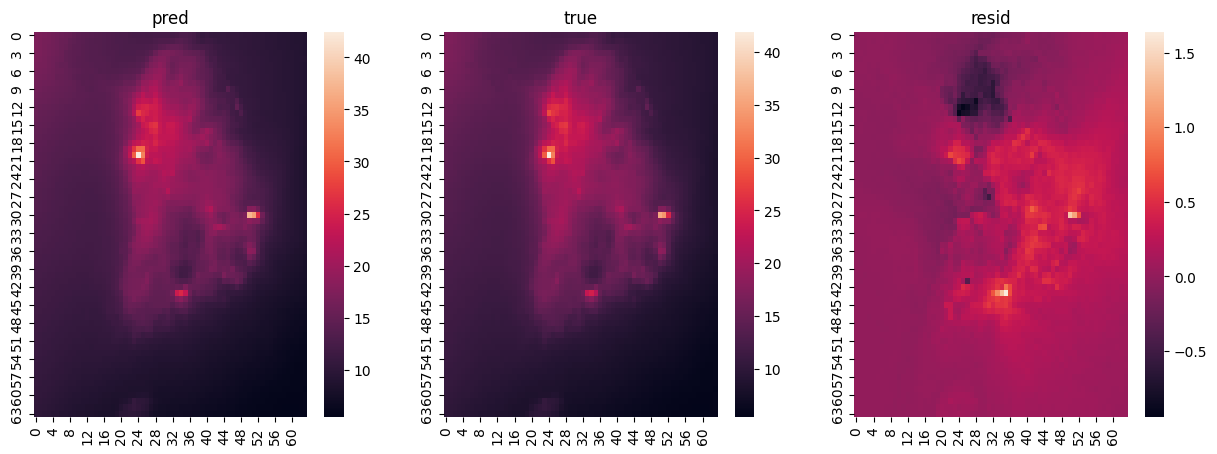

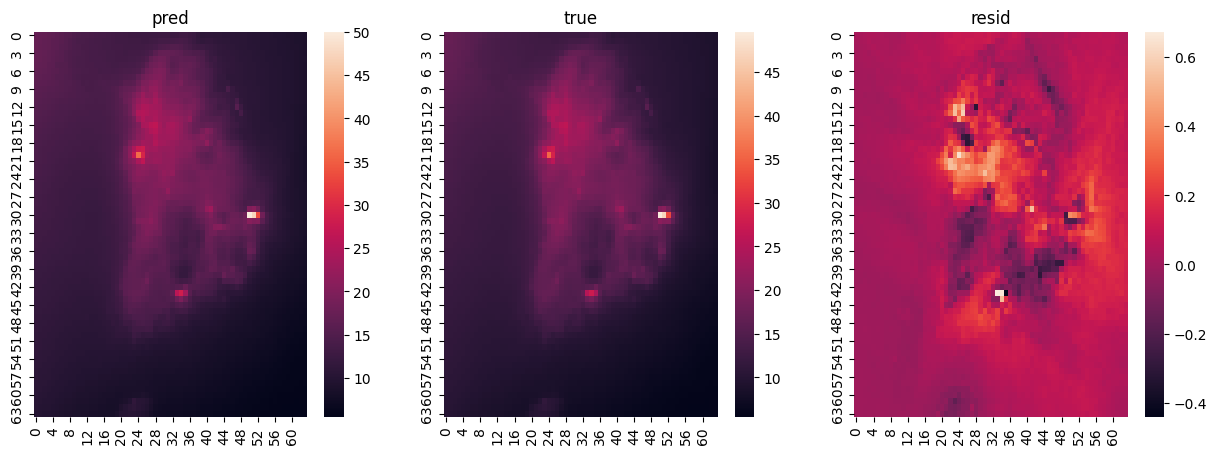

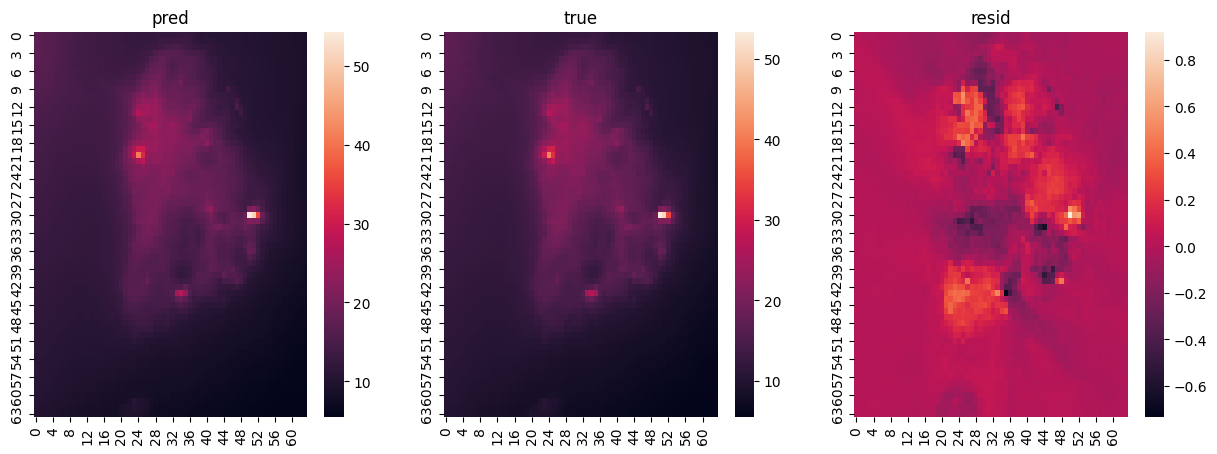

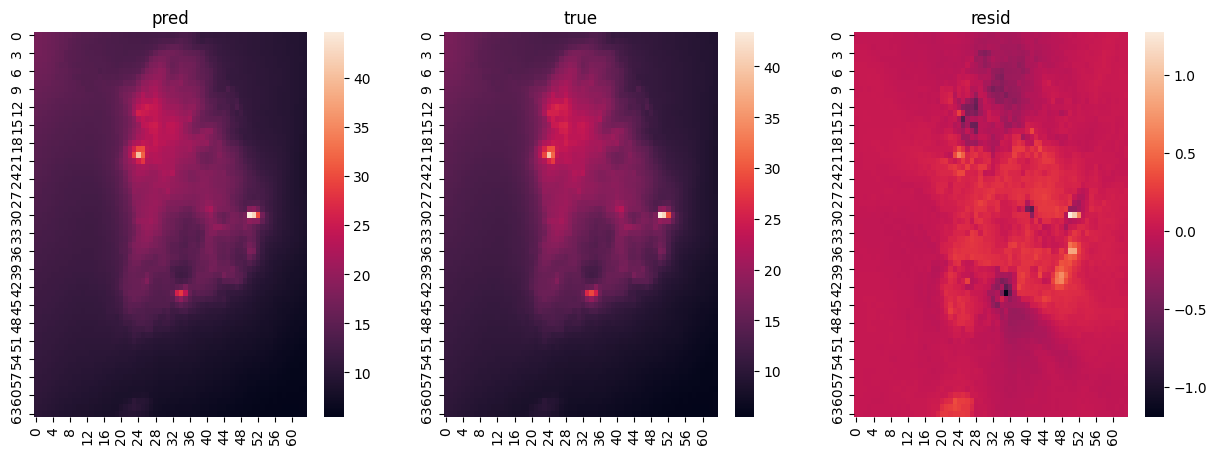

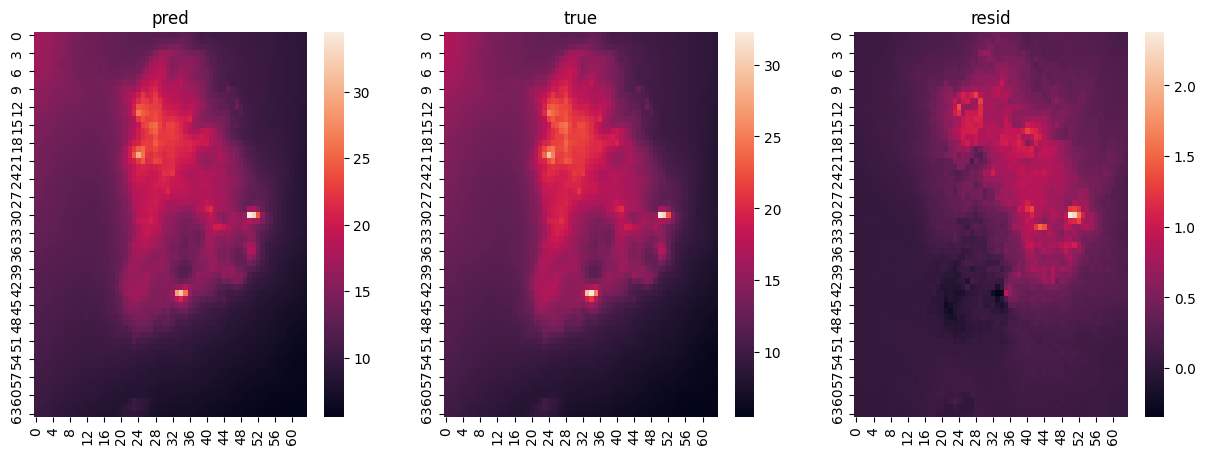

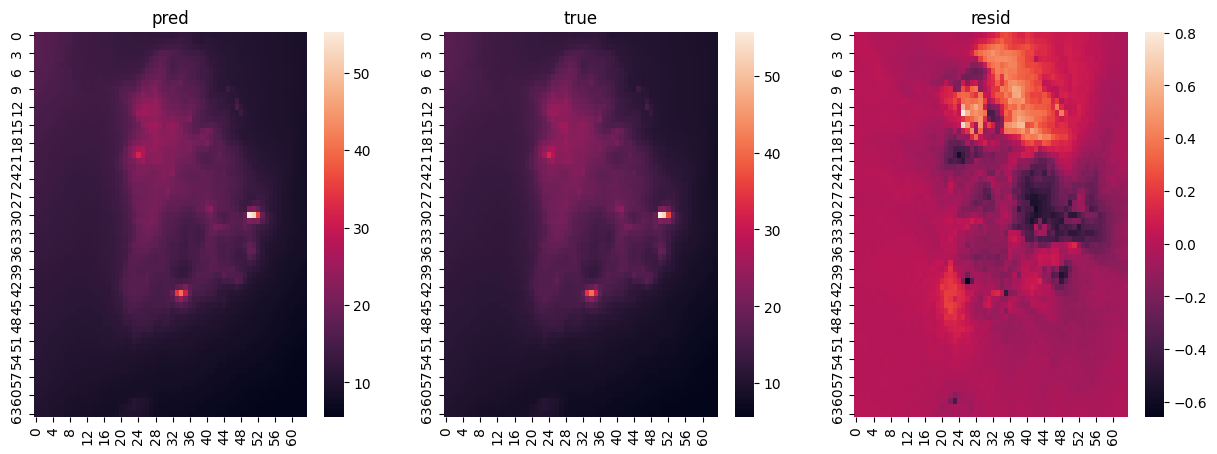

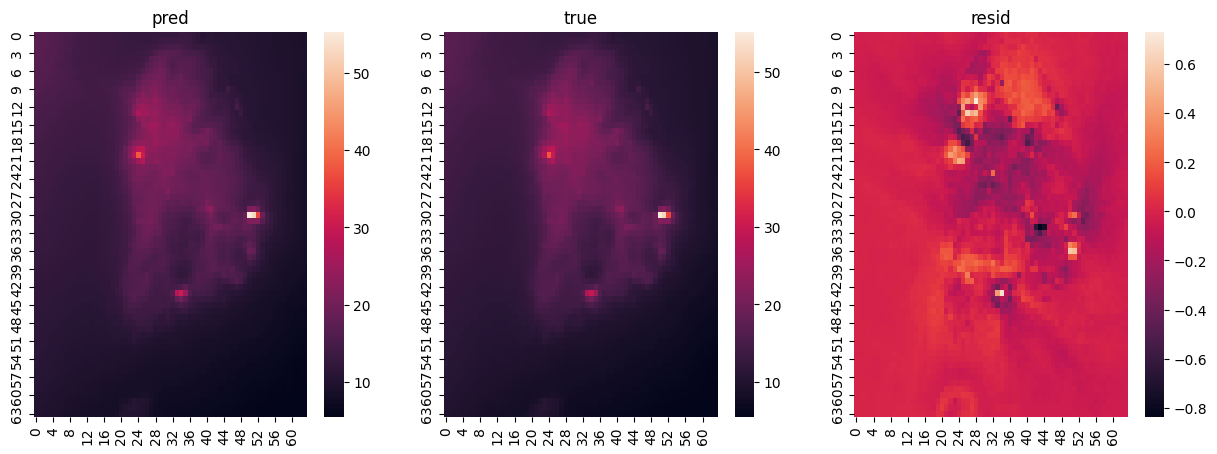

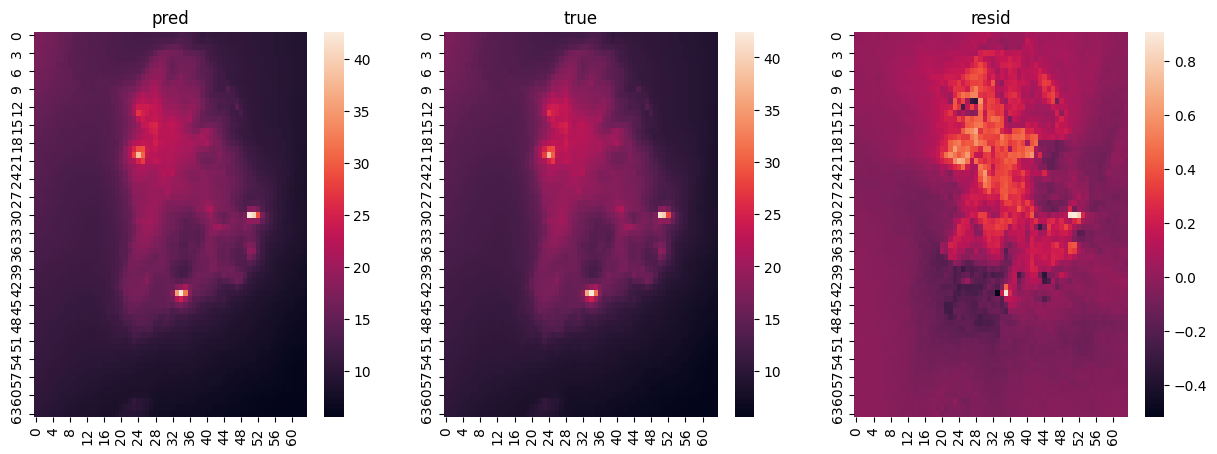

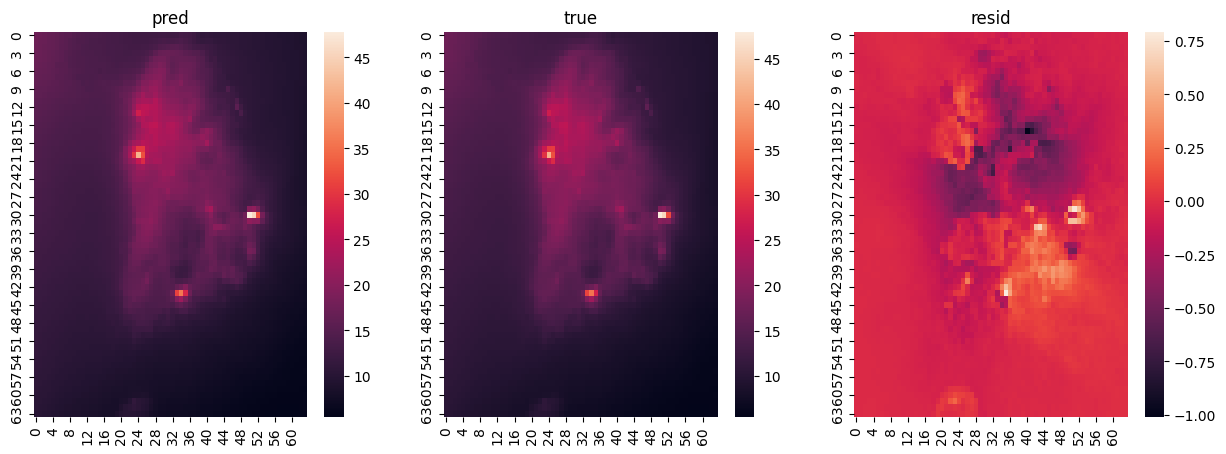

In [35]:
# asdasd
for i in range(len(y_test)):
    plt.figure(figsize = [15,5])
    plt.subplot(1,3,1)
    plt.title('pred')
    sns.heatmap(pred_base[i,:,:,0][::-1])
    plt.subplot(1,3,2)
    plt.title('true')
    sns.heatmap(y_test[i,:,:,0][::-1])
    plt.subplot(1,3,3)
    plt.title('resid')
    sns.heatmap(pred_base[i,:,:,0][::-1] - y_test[i,:,:,0][::-1])